# longer session length indicative of higher fraud occurence

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pointbiserialr
import warnings


# Read the CSV file into a DataFrame
df = pd.read_csv('undersampled_data.csv')

Mean session_length_in_minutes for fraud cases: 8.243746813906647
Mean session_length_in_minutes for legitimate cases: 7.557075977022658


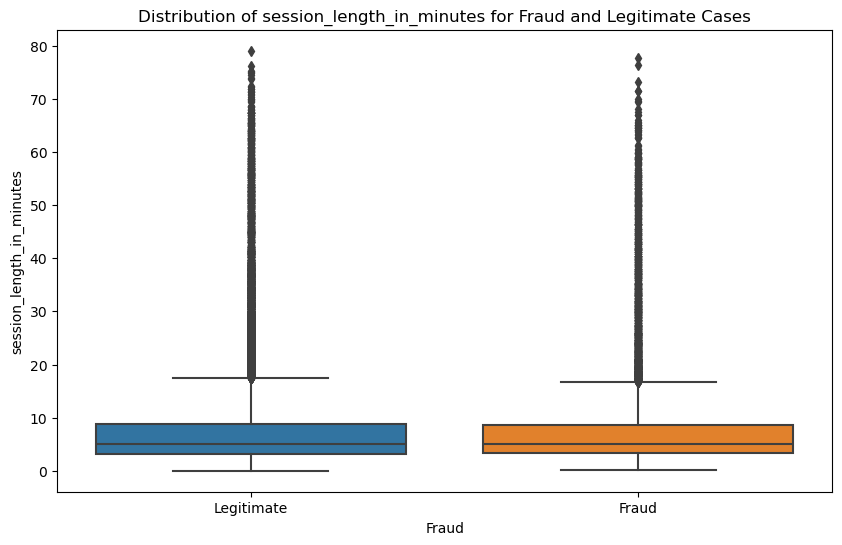

T-Statistic: 7.872764889847723
P-Value: 3.5213620107339216e-15
Reject the null hypothesis. There is a significant difference in session_length_in_minutes between fraud and legitimate cases.


In [40]:
fraud_mean_similarity = df[df['fraud_bool'] == 1]['session_length_in_minutes'].mean()
legit_mean_similarity = df[df['fraud_bool'] == 0]['session_length_in_minutes'].mean()

print("Mean session_length_in_minutes for fraud cases:", fraud_mean_similarity)
print("Mean session_length_in_minutes for legitimate cases:", legit_mean_similarity)

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraud_bool', y='session_length_in_minutes', data=df)
plt.title('Distribution of session_length_in_minutes for Fraud and Legitimate Cases')
plt.xlabel('Fraud')
plt.ylabel('session_length_in_minutes')
plt.xticks([0, 1], ['Legitimate', 'Fraud'])
plt.show()

# Statistical Testing
t_stat, p_value = ttest_ind(df[df['fraud_bool'] == 1]['session_length_in_minutes'],
                             df[df['fraud_bool'] == 0]['session_length_in_minutes'])

print("T-Statistic:", t_stat)
print("P-Value:", p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in session_length_in_minutes between fraud and legitimate cases.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in session_length_in_minutes between fraud and legitimate cases.")


In [2]:
# test for normality of predictive features
warnings.filterwarnings("ignore")

# Shapiro-Wilk test for session length of fraudulent accounts


# Subset data for fraudulent and legitimate accounts
fraudulent_accounts = df[df['fraud_bool'] == 1]
legitimate_accounts = df[df['fraud_bool'] == 0]

shapiro_stat_fraud, p_value_fraud = shapiro(fraudulent_accounts['session_length_in_minutes'].dropna())
print("Shapiro-Wilk test for session length of fraudulent accounts:")
print("Statistic:", shapiro_stat_fraud)
print("P-Value:", p_value_fraud)

# Shapiro-Wilk test for session length of legitimate accounts
shapiro_stat_legit, p_value_legit = shapiro(legitimate_accounts['session_length_in_minutes'].dropna())
print("\nShapiro-Wilk test for session length of legitimate accounts:")
print("Statistic:", shapiro_stat_legit)
print("P-Value:", p_value_legit)

Shapiro-Wilk test for session length of fraudulent accounts:
Statistic: 0.6348894834518433
P-Value: 0.0

Shapiro-Wilk test for session length of legitimate accounts:
Statistic: 0.6705756187438965
P-Value: 0.0


In [3]:

# things to note:
# Shapiro-Wilk test may not be accurate since sample size is > 5000

# suppose choose significance level = 0.05 
# p value for both fraud and legit cases are very small, less than significance level
# cannot assume distribution of 'session_length_in_minutes' for both cases is normal - so using t-test is not accurate


# # alternative is use feature engineering
# create categorical bins using 'session_length_in_minutes'and visualize the distribution of the new categorical feature for fraud and legit cases
# transform the continuous session_length_in_minutes feature into a categorical feature

In [4]:

session_length = df['session_length_in_minutes']
fraud = df['fraud_bool']

# Calculate point biserial correlation coefficient and its p-value
correlation_coefficient, p_value = pointbiserialr(session_length, fraud)

print("Point Biserial Correlation Coefficient:", correlation_coefficient)
print("p-value:", p_value)


Point Biserial Correlation Coefficient: 0.030637737982589907
p-value: 3.521362011151622e-15


In [5]:
# correlation coefficient suggests positive correlation between session length and the likelihood of fraud
# positive value indicates that as session length increases, there's a slight tendency for fraud to be more likely.

# p value is extremely small, indicating strong evidence against the null hypothesis that there is no correlation between session length and fraud

# result suggest that session length may have some influence on fraudulent activity

In [6]:
# since 'session_length_in_minutes' not normal, use Mann-Whitney U test to check

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(fraudulent_accounts['session_length_in_minutes'], 
                                   legitimate_accounts['session_length_in_minutes'])

print("Mann-Whitney U Test Statistic:", statistic)
print("P-Value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in session length between fraud and legitimate cases.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in session length between fraud and legitimate cases.")


Mann-Whitney U Test Statistic: 306236059.5
P-Value: 0.027784095029656803
Reject the null hypothesis. There is a significant difference in session length between fraud and legitimate cases.


In [23]:
# strong evidence against null hypothesis that there is no difference in session length between fraudulent and legitimate accounts.
# p value small < 0.05  means that there is sufficient evidence to conclude that there is a significant difference in session length between fraudulent and legitimate cases.
# applicants with longer session lengths are more likely to be involved in fraud compared to those with shorter session lengths. 

# use feature engineering, implement new column 'session_length_bins' to test the association with fraud occurences

In [7]:
# # alternative is use feature engineering
# create categorical bins using 'session_length_in_minutes'and visualize the distribution of the new categorical feature for fraud and legit cases
# transform the continuous session_length_in_minutes feature into a categorical feature

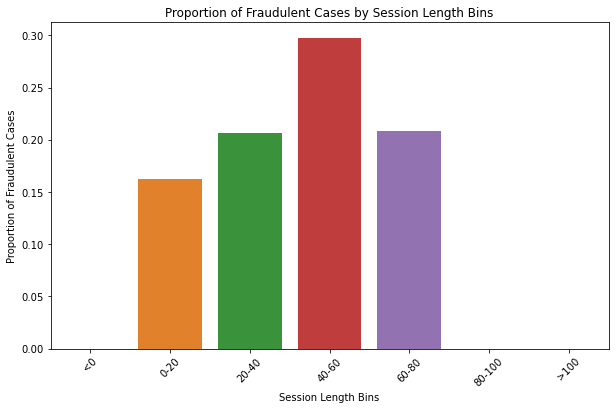

Chi-square Statistic: 148.70688358611807
P-Value: 5.008500096485462e-32
Reject the null hypothesis. There is a significant association between session length bins and fraud occurrence.


In [3]:


# specify the bin edges
bin_edges = [-10, 0, 20, 40, 60, 80, 100, 300]

# define bin labels
bin_labels = ['<0', '0-20', '20-40', '40-60', '60-80', '80-100', '>100']

# create the new column with binned values
df['session_length_bins'] = pd.cut(df['session_length_in_minutes'], bins=bin_edges, labels=bin_labels)


# Calculate the proportion of fraudulent cases in each session length bin
fraud_proportion_by_bin = df.groupby('session_length_bins')['fraud_bool'].mean()

# Plot the relationship between session length bins and the proportion of fraudulent cases
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_proportion_by_bin.index, y=fraud_proportion_by_bin.values)
plt.title('Proportion of Fraudulent Cases by Session Length Bins')
plt.xlabel('Session Length Bins')
plt.ylabel('Proportion of Fraudulent Cases')
plt.xticks(rotation=45)
plt.show()

# Conduct statistical testing (e.g., chi-square test)
# Chi-square test of independence
chi2_stat, p_val, _, _ = chi2_contingency(pd.crosstab(df['session_length_bins'], df['fraud_bool']))

print("Chi-square Statistic:", chi2_stat)
print("P-Value:", p_val)

alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis. There is a significant association between session length bins and fraud occurrence.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between session length bins and fraud occurrence.")


In [27]:
# null hypothesis: no association between session length bins and fraud occurrence
# rej null to conclude that there is a significant association between session length bins and fraud occurrence
# different session length bins are associated with different rates of fraudulent activity

# results suggests that longer sessions = higher fraud rates

# to note:
# proportion of fraud in each bin = number of fraud accs in the bin / total number of accs in the bin

In [26]:
# statistical testing 
# Point-biserial correlation
corr_coeff, p_val = pointbiserialr(df['session_length_bins'].cat.codes, df['fraud_bool'])

print("Point-Biserial Correlation Coefficient:", corr_coeff)
print("P-Value:", p_val)

alpha = 0.05
if p_val < alpha:
    if corr_coeff > 0:
        print("Positive association: Longer session lengths are associated with a higher proportion of fraudulent cases.")
    else:
        print("Negative association: Longer session lengths are associated with a lower proportion of fraudulent cases.")
else:
    print("No significant association found.")

Point-Biserial Correlation Coefficient: 0.04389683810585896
P-Value: 1.6481726351776904e-29
Positive association: Longer session lengths are associated with a higher proportion of fraudulent cases.


In [29]:
# supports the hypothesis that the longer length sessions indicative of higher fraud occurences


# test the effectiveness of using session_length_in_minutes and credit_risk_score as important predictor for fraud detection and prevention strategies

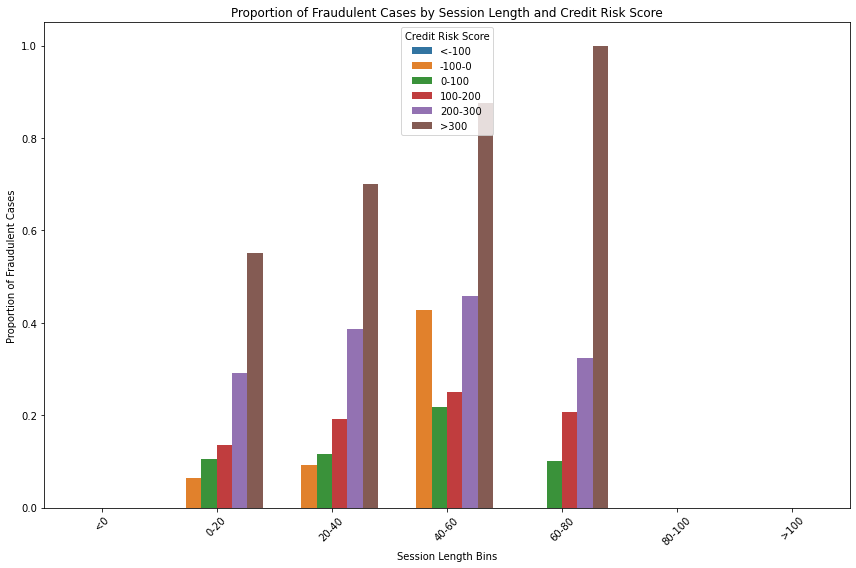

In [4]:
# test the effectiveness of using session_length_in_minutes and credit_risk_score as important predictor for fraud detection

# Define session length bins
session_length_bins = pd.cut(df['session_length_in_minutes'], bins=[-10, 0, 20, 40, 60, 80, 100, 300],
                              labels=['<0', '0-20', '20-40', '40-60', '60-80', '80-100', '>100'])



# Add session length bins to the DataFrame
df['session_length_bins'] = session_length_bins

# Manually select intervals for credit risk score bins
credit_risk_score_bins = pd.cut(df['credit_risk_score'], bins=[-176, -100, 0, 100, 200, 300, 400],
                                labels=['<-100', '-100-0', '0-100', '100-200', '200-300', '>300'])



# Add credit risk score bins to the DataFrame
df['credit_risk_score_bins'] = credit_risk_score_bins

# Group by credit risk score and session length bins, calculate proportion of fraudulent cases
fraud_proportion_by_bin = df.groupby(['credit_risk_score_bins', 'session_length_bins'])['fraud_bool'].mean().reset_index()

# Plot the relationship between session length bins and proportion of fraudulent cases for each credit risk score bin
plt.figure(figsize=(12, 8))
sns.barplot(x='session_length_bins', y='fraud_bool', hue='credit_risk_score_bins', data=fraud_proportion_by_bin)
plt.title('Proportion of Fraudulent Cases by Session Length and Credit Risk Score')
plt.xlabel('Session Length Bins')
plt.ylabel('Proportion of Fraudulent Cases')
plt.xticks(rotation=45)
plt.legend(title='Credit Risk Score')
plt.tight_layout()
plt.show()

In [31]:
# consistent with above results where longer sessions suggests higher fraud rates
# higher credit_risk_score = higher fraud rates

# possible reasons to explain this pattern

In [17]:
# fraudsters may engage in more elaborate and sophisticated fraud schemes during longer sessions, using the extended time to manipulate account information or bypass security measures

# If bots are used to do the applications, likely to take longer to plan and execute their fraudulent activities

# Fraud accounts would want to avoid fraud detection systems. So having longer sessions would create more data for analysis and increase computational burden on the detection systems. Longer sessions will create more data points and complexity which makes it harder for the systems to separate fraud and legit
